In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os, sys

import mne

In [2]:
ROOT = "/scratch/alr664/"
os.chdir(ROOT)

exp = ROOT + "multiple_affix/"
logs = exp + "logs/"

full_dataset = ["A0394", "A0421", "A0446", "A0451", "A0468", "A0484", "A0495", "A0502", "A0503", "A0508", 
                "A0509", "A0512", "A0513", "A0514", "A0516", "A0517", "A0518", "A0519", "A0520", "A0521", 
                "A0522", "A0523", "A0524", "A0525"]

# 1 more metadata than events "A0451", # solved? "A0508",
# 1898 events - "A0521","A0523","A0524","A0525",
# 1892 events - "A0518","A0522",

In [3]:
len(full_dataset)

24

In [4]:
event_ids = {
    '0Suff w/ Lat': 1,
    '0Suff w/o Lat.': 2,
    '0Suff NW': 4,
    '1Suff w/ Lat.': 11,
    '1Suff w/o Lat.': 12,
    '1Suff PseudoStemNW': 14,
    '1Suff RealStemNW': 15,
    '2Suff w/ Lat.': 21,
    '2Suff w/o Lat.': 22,
    '2Suff Composite': 23,
    '2Suff PseudoStemNW': 24,
    '2Suff RealStemNW': 25
}

#'practice': 99

nonwords = [4, 14, 15, 24] 
realwords = [1, 2, 11, 12, 21, 22, 23, 25] 

In [13]:
for subj in full_dataset:
    print(subj)

    raw_fname = f"{exp}/meg/{subj}/{subj}_MA_ICA-raw.fif"
    epochs_fname = f"{exp}/meg/{subj}/{subj}_rejection-epo.fif"
    pattern = os.path.join(logs, f"{subj}_MA_Block*_*.csv")
    file_paths = glob.glob(pattern)
    
    df_list = []
    for file_path in file_paths:
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            block_number = int(file_path.split('_')[3][5])
            df['block'] = block_number
            df_list.append(df)

    if df_list:
        df_list = sorted(df_list, key=lambda x: x['block'].iloc[0])
        logfiles = pd.concat(df_list, ignore_index=True)
    else:
        logfiles = pd.DataFrame()

    if not logfiles.empty:
        raw = mne.io.read_raw_fif(raw_fname, preload=True)
        info = raw.info
        sfreq = info['sfreq']
        picks_meg = mne.pick_types(info, meg=True, eeg=False, eog=False, stim=False)
        print(raw.times)
        events = mne.find_events(raw, min_duration=0.002)
        logfile_deduplicated = logfiles.drop_duplicates(subset='Word', keep='first')
        epochs = mne.Epochs(raw, events, event_id=event_ids, tmin=-0.2, tmax=0.6,
                            preload=True, picks = picks_meg, baseline=(-0.1, 0))

        reject = {'mag': 3e-10}
        epochs.drop_bad(reject)
        #epochs.resample(sfreq=125)
        epochs.save(epochs_fname, overwrite = True)
        print('Epochs saved.')
        del epochs
    else:
        print(f"No log files available for subject {subj}")


A0394
Opening raw data file /scratch/alr664/multiple_affix//meg/A0394/A0394_MA_ICA-raw.fif...
    Range : 0 ... 2086999 =      0.000 ...  2086.999 secs
Ready.
Opening raw data file /scratch/alr664/multiple_affix/meg/A0394/A0394_MA_ICA-raw-1.fif...
    Range : 2087000 ... 2310999 =   2087.000 ...  2310.999 secs
Ready.
Reading 0 ... 2310999  =      0.000 ...  2310.999 secs...
[0.000000e+00 1.000000e-03 2.000000e-03 ... 2.310997e+03 2.310998e+03
 2.310999e+03]
1898 events found on stim channel STI 014
Event IDs: [ 1  2  4 11 12 14 15 21 22 23 24 25 99]
Not setting metadata
1886 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1886 events and 801 original time points ...
0 bad epochs dropped
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
[-0.2   -0.199 -0.198 -0.197 -0.196 -0.195 -0.194 -0.193 -0.192 -0.191
 -0.19  -0.189 -0.188 -0.187 -0.186 -0.185 -0.184 -0.183 -0.182 -0.181
 -0.18  

Opening raw data file /scratch/alr664/multiple_affix//meg/A0421/A0421_MA_ICA-raw.fif...
    Range : 0 ... 2086999 =      0.000 ...  2086.999 secs
Ready.
Opening raw data file /scratch/alr664/multiple_affix/meg/A0421/A0421_MA_ICA-raw-1.fif...
    Range : 2087000 ... 2349999 =   2087.000 ...  2349.999 secs
Ready.
Reading 0 ... 2349999  =      0.000 ...  2349.999 secs...


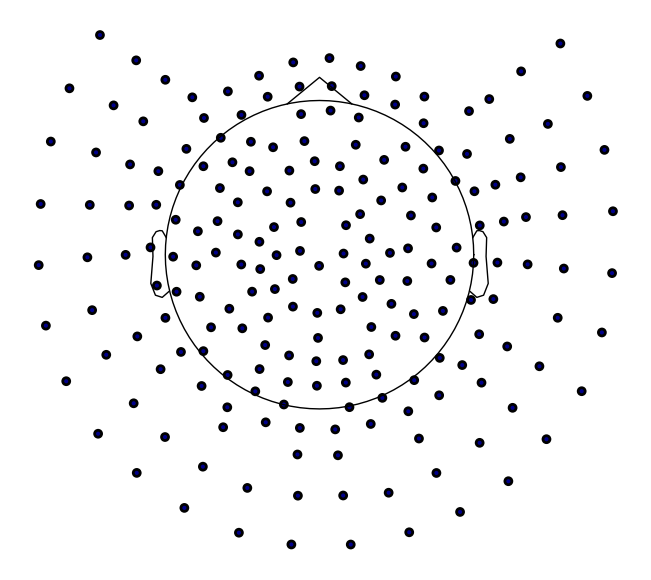

In [8]:
subj = 'A0421'
raw_fname = f"{exp}/meg/{subj}/{subj}_MA_ICA-raw.fif"
raw = mne.io.read_raw_fif(raw_fname, preload=True)
fig = raw.plot_sensors()

plot_name = "channel_topo" 
output_dir = "plots" 
os.makedirs(output_dir, exist_ok=True) 

# fig = combined_evoked.plot_joint(picks='mag')
fig.savefig(f"{output_dir}/{plot_name}.pdf", format='pdf')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import mne
from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

evoked_dict = {key: [] for key in event_ids.keys()}
for subj in full_dataset:
    print(subj)
    epo_fname = f"{exp}/meg/{subj}/{subj}_rejection-epo.fif"
    epochs = mne.read_epochs(epo_fname)

    epochs.pick(picks="meg", exclude="bads")  # remove stim and EOG

    X = epochs.get_data(copy=False)  # MEG signals: n_epochs, n_meg_channels, n_times
    y = epochs.events[:, 2]

    # Uses all MEG sensors and time points as separate classification
    # features, so the resulting filters used are spatio-temporal
    clf = make_pipeline(
        Scaler(epochs.info),
        Vectorizer(),
        LogisticRegression(solver="liblinear"),  # liblinear is faster than lbfgs
    )
    
    scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=14)
    
    # Mean scores across cross-validation splits
    score = np.mean(scores, axis=0)
    print(f"Spatio-temporal: {100 * score:0.1f}%")

A0394
Reading /scratch/alr664/multiple_affix/meg/A0394/A0394_rejection-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
1886 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


In [ ]:
print(event_ids.keys())
print(evoked_dict.keys())

In [33]:
evoked_dict = {key: [] for key in event_ids.keys()}
for subj in full_dataset:
    print(subj)
    epo_fname = f"{exp}/meg/{subj}/{subj}_rejection-epo.fif"
    # epochs = mne.read_epochs(epo_fname)
    for condition, event_id in event_ids.items():
        # evoked = epochs[condition].average()
        evoked_dir = f"{exp}/meg/{subj}/evoked"
        condition_safe = condition.replace(" ", "_").replace("/", "_").replace(".", "")
        evoked_fname = f"{evoked_dir}/{condition_safe}-ave.fif" 
        # evoked.save(evoked_fname, overwrite=True)
        evoked = mne.read_evokeds(evoked_fname)[0]
        evoked_dict[condition].append(evoked)

A0394
Reading /scratch/alr664/multiple_affix/meg/A0394/evoked/0Suff_w__Lat-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms (0Suff w/ Lat)
        0 CTF compensation matrices available
        nave = 30 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.1, 0] s)
Reading /scratch/alr664/multiple_affix/meg/A0394/evoked/0Suff_w_o_Lat-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms (0Suff w/o Lat.)
        0 CTF compensation matrices available
        nave = 227 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.1, 0] s)
Reading /scratch/alr664/multiple_affix/meg/A0394/evoked/0Suff_NW-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms (0Suff NW)
        0 CTF compensation 

No projector specified for this dataset. Please consider the method self.add_proj.


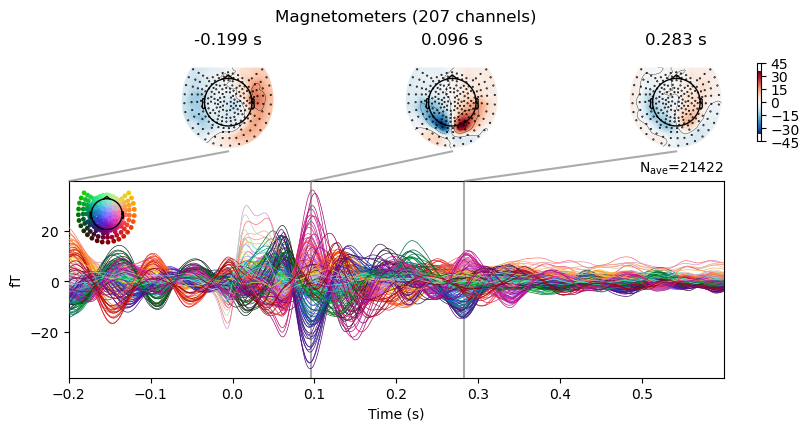

In [29]:
evoked_list = non_words_evokeds
weights = np.ones(len(evoked_list))  # Equal weighting for averaging
combined_evoked = mne.combine_evoked(evoked_list, weights='equal')

plot_name = "nonword_topo" 
output_dir = "plots" 
os.makedirs(output_dir, exist_ok=True) 

fig = combined_evoked.plot_joint(picks='mag')
fig.savefig(f"{output_dir}/{plot_name}.pdf", format='pdf')

Identifying common channels ...


/state/partition1/job-47233002/ipykernel_1911761/3464886002.py:19: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.evoked.Evoked'>.tmax (0.6 s)
  real_words_grand_average = mne.grand_average(real_words_evokeds).crop(0,0.6)


Identifying common channels ...


/state/partition1/job-47233002/ipykernel_1911761/3464886002.py:20: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.evoked.Evoked'>.tmax (0.6 s)
  non_words_grand_average = mne.grand_average(non_words_evokeds).crop(0,0.6)


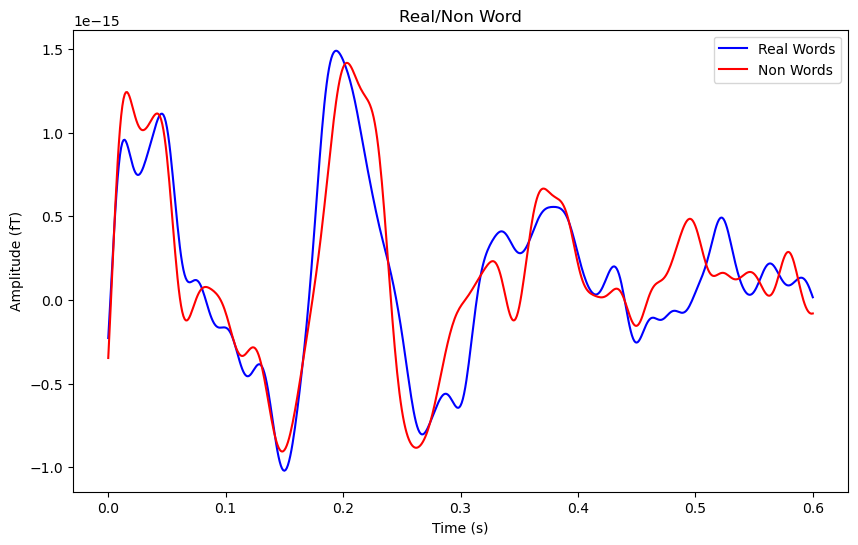

In [34]:
latinates = ['0Suff w/ Lat','1Suff w/ Lat.','2Suff w/ Lat.']
non_latinates = ['0Suff w/o Lat.','1Suff w/o Lat.','2Suff w/o Lat.']
composites = ['2Suff Composite']

real_words = latinates + non_latinates + composites
non_words = [word for word in event_ids.keys() if word not in real_words]

# non_words = ['0Suff NW', '1Suff PseudoStemNW', '1Suff RealStemNW', '2Suff PseudoStemNW', '2Suff RealStemNW'] 
# real_words = ['0Suff w/ Lat', '0Suff w/o Lat.', '1Suff w/ Lat.', '1Suff w/o Lat.', '2Suff w/ Lat.', '2Suff w/o Lat.', '2Suff Composite'] 

real_words_evokeds = []
non_words_evokeds = []

for condition in real_words:
    real_words_evokeds.extend(evoked_dict[condition])
for condition in non_words:
    non_words_evokeds.extend(evoked_dict[condition])

real_words_grand_average = mne.grand_average(real_words_evokeds).crop(0,0.6)
non_words_grand_average = mne.grand_average(non_words_evokeds).crop(0,0.6)

all_evokeds = [real_words_evokeds, non_words_evokeds]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(real_words_grand_average.times, real_words_grand_average.data.mean(axis=0), label='Real Words', color='blue')
ax.plot(non_words_grand_average.times, non_words_grand_average.data.mean(axis=0), label='Non Words', color='red')

ax.set_title('Real/Non Word')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (fT)')
ax.legend()
plt.show()

plot_name = "real_non_word_evoked_responses"
output_dir = "plots"  
os.makedirs(output_dir, exist_ok=True) 

fig.savefig(f"{output_dir}/{plot_name}.pdf", format='pdf')

In [ ]:
epochs.get_data().shape
len(epochs.get_data()[-1])